# PatchMatch Evaluation on VO (Visual Odometry) Dataset

### Import Required Libraries and Packages

In [1]:
import os
import glob
import sys
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
module_path = os.path.abspath(os.path.join('..', 'modules'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from patchmatch import PatchMatch

### ORB Matching Pipeline Evaluation

In [56]:
folder_path = os.path.abspath(os.path.join('..', 'media/sequence_50/images'))
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
image_files.sort()

image_pairs = []
for i in range(len(image_files) - 1):
    img1_path = os.path.join(folder_path, image_files[i])
    image_1 = cv2.imread(img1_path)
    
    img2_path = os.path.join(folder_path, image_files[i + 1])
    image_2 = cv2.imread(img2_path)

    image_1_gray = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    image_2_gray = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
    
    orb = cv2.ORB_create(nfeatures=500)
    keypoints1, descriptors1 = orb.detectAndCompute(image_1_gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(image_2_gray, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches = bf.match(descriptors1, descriptors2)

    matches = sorted(matches, key = lambda x:x.distance)

    points1 = []
    points2 = []

    for match in matches:
        points1.append(keypoints1[match.queryIdx].pt)
        points2.append(keypoints2[match.trainIdx].pt)

    points1 = np.array(points1, dtype=np.int32)
    points2 = np.array(points2, dtype=np.int32)

    fundamental_matrix, inliers = cv2.findFundamentalMat(points1, points2, method=cv2.FM_RANSAC, ransacReprojThreshold=1.0, confidence=0.99)

    inliers = inliers.ravel().astype(bool)
    points1 = points1[inliers]
    points2 = points2[inliers]

    combined_image = np.hstack((image_1, image_2))

    for index in range(len(points1)):
        cv2.line(combined_image, (points1[index][0], points1[index][1]), (points2[index][0] + image_1.shape[1],  points2[index][1]), (0, 255, 0), 1)

    cv2.putText(combined_image, f'ORB Matching Pipeline', (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 4, cv2.LINE_AA)
    cv2.putText(combined_image, f'Number of Matches: {len(points1)}', (20, 130), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 4, cv2.LINE_AA)
    
    plt.figure(figsize=(14, 8))
    plt.imshow(combined_image)
    plt.axis('off')
    plt.savefig(os.path.abspath(os.path.join('..', f'media/sequence_50/matching/orb/orb_{i}.png')), bbox_inches='tight', pad_inches=0)
    # plt.show()
    plt.close()

### PatchMatch Pipeline Evaluation

In [57]:
folder_path = os.path.abspath(os.path.join('..', 'media/sequence_50/images'))
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
image_files.sort()

image_pairs = []
for i in range(len(image_files) - 1):
    img1_path = os.path.join(folder_path, image_files[i])
    image_1 = cv2.imread(img1_path)
        
    img2_path = os.path.join(folder_path, image_files[i + 1])
    image_2 = cv2.imread(img2_path)
    
    pm = PatchMatch(match_feature='ORB', num_features=500)
    points1, points2 = pm.match_two_images(image_1, image_2)

    fundamental_matrix, inliers = cv2.findFundamentalMat(points1, points2, method=cv2.FM_RANSAC, ransacReprojThreshold=1.0, confidence=0.99)

    inliers = inliers.ravel().astype(bool)
    points1 = points1[inliers]
    points2 = points2[inliers]

    combined_image = np.hstack((image_1, image_2))

    for index in range(len(points1)):
        cv2.line(combined_image, (points1[index][0], points1[index][1]), (points2[index][0] + image_1.shape[1],  points2[index][1]), (0, 255, 0), 1)

    cv2.putText(combined_image, f'PatchMatch (ORB) Matching Pipeline', (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 4, cv2.LINE_AA)
    cv2.putText(combined_image, f'Number of Matches: {len(points1)}', (20, 130), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 4, cv2.LINE_AA)
    
    plt.figure(figsize=(14, 8))
    plt.imshow(combined_image)
    plt.axis('off')
    plt.savefig(os.path.abspath(os.path.join('..', f'media/sequence_50/matching/patchmatch/patchmatch_{i}.png')), bbox_inches='tight', pad_inches=0)
    # plt.show()
    plt.close()

### Create GIF from Matching Sequences

In [33]:
def make_gif(frame_folder):
    image_files = [f for f in os.listdir(frame_folder) if os.path.isfile(os.path.join(frame_folder, f))]
    image_files.sort()
    
    frames = [Image.open(os.path.join(frame_folder, image_path)) for image_path in image_files]
    
    frame_one = frames[0]
    frame_one.save(os.path.abspath(os.path.join('..', f'media/patchmatch.gif')), format="GIF", append_images=frames,
                   save_all=True, duration=100, loop=0)

In [32]:
make_gif(os.path.abspath(os.path.join('..', f'media/sequence_50/matching/orb')))

In [34]:
make_gif(os.path.abspath(os.path.join('..', f'media/sequence_50/matching/patchmatch')))

### ORB vs PatchMatch Timing Analysis on CPU

In [5]:
folder_path = os.path.abspath(os.path.join('..', 'data/hpatches-resized/v_abstract'))
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith('.ppm')]
image_files.sort()

elapsed_time_orb = 0
num_matches_orb = 0

image_pairs = []
for i in range(len(image_files) - 1):
    img1_path = os.path.join(folder_path, image_files[i])
    image_1 = cv2.imread(img1_path)
    
    img2_path = os.path.join(folder_path, image_files[i + 1])
    image_2 = cv2.imread(img2_path)

    start_time = time.perf_counter()
    
    image_1_gray = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    image_2_gray = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)

    orb = cv2.ORB_create(nfeatures=250)
    keypoints1, descriptors1 = orb.detectAndCompute(image_1_gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(image_2_gray, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches = bf.match(descriptors1, descriptors2)

    matches = sorted(matches, key = lambda x:x.distance)

    points1 = []
    points2 = []

    for match in matches:
        points1.append(keypoints1[match.queryIdx].pt)
        points2.append(keypoints2[match.trainIdx].pt)

    points1 = np.array(points1, dtype=np.int32)
    points2 = np.array(points2, dtype=np.int32)

    H, inliers = cv2.findHomography(points1, points2, cv2.RANSAC, 5.0)

    inliers = inliers.ravel().astype(bool)
    points1 = points1[inliers]
    points2 = points2[inliers]

    end_time = time.perf_counter()

    elapsed_time_orb += end_time - start_time
    num_matches_orb += len(points1)

elapsed_time_orb /= len(image_files) - 1
orb_fps = int(1 / elapsed_time_orb)
num_matches_orb /= len(image_files) - 1
num_matches_orb = int(num_matches_orb)

print(orb_fps)
print(num_matches_orb)

56
70


In [8]:
folder_path = os.path.abspath(os.path.join('..', 'data/hpatches-resized/v_abstract'))
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith('.ppm')]
image_files.sort()

elapsed_time_patchmatch = 0
num_matches_patchmatch = 0

image_pairs = []
for i in range(len(image_files) - 1):
    img1_path = os.path.join(folder_path, image_files[i])
    image_1 = cv2.imread(img1_path)
    
    img2_path = os.path.join(folder_path, image_files[i + 1])
    image_2 = cv2.imread(img2_path)

    start_time = time.perf_counter()

    pm = PatchMatch(match_feature='ORB', num_features=250)
    points1, points2 = pm.match_two_images(image_1, image_2)

    H, inliers = cv2.findHomography(points1, points2, cv2.RANSAC, 5.0)

    inliers = inliers.ravel().astype(bool)
    points1 = points1[inliers]
    points2 = points2[inliers]

    end_time = time.perf_counter()

    elapsed_time_patchmatch += end_time - start_time
    num_matches_patchmatch += len(points1)

elapsed_time_patchmatch /= len(image_files) - 1
patchmatch_fps = int(1 / elapsed_time_patchmatch)
num_matches_patchmatch /= len(image_files) - 1
num_matches_patchmatch = int(num_matches_patchmatch)

print(patchmatch_fps)
print(num_matches_patchmatch)

12
208


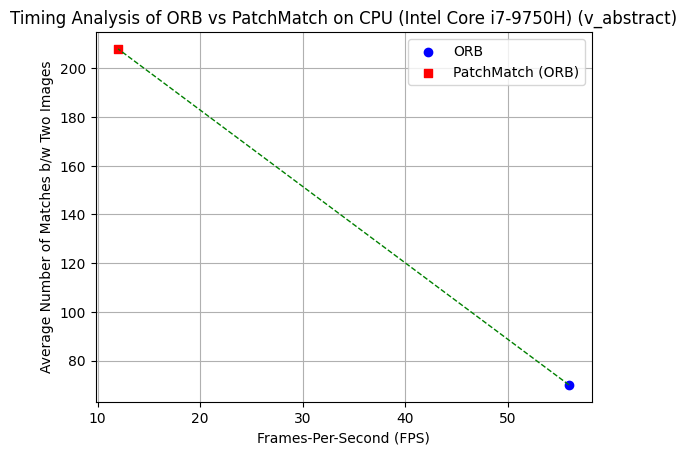

In [11]:
plt.scatter(orb_fps, num_matches_orb, color='blue', marker='o', label='ORB')
plt.scatter(patchmatch_fps, num_matches_patchmatch, color='red', marker='s', label='PatchMatch (ORB)')
plt.plot([orb_fps, patchmatch_fps], [num_matches_orb, num_matches_patchmatch], color='green', linestyle='dashed', linewidth=1)
plt.title('Timing Analysis of ORB vs PatchMatch on CPU (Intel Core i7-9750H) (v_abstract)')
plt.xlabel('Frames-Per-Second (FPS)')
plt.ylabel('Average Number of Matches b/w Two Images')
plt.grid()
plt.legend()
plt.savefig(os.path.abspath(os.path.join('..', f'media/timing_analysis.png')), bbox_inches='tight', pad_inches=0.1)
plt.show()